In [1]:
import os
import torch
from torchsummary import summary

from det3d import torchie
from det3d.models import build_detector
from det3d.torchie.parallel import MegDataParallel
from det3d.torchie.trainer import load_checkpoint

from torch.utils.data import DataLoader
from det3d.datasets import build_dataset
from det3d.torchie.parallel import collate_kitti
from det3d.torchie.trainer.trainer import example_to_device

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%matplotlib inline

True


/home/liyue/.conda/envs/torch1.8/lib/python3.8/site-packages/scikit_image-0.19.3-py3.8-linux-x86_64.egg/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
cfg = torchie.Config.fromfile("../examples/second/configs/config.py")

In [3]:
# data part
dataset = build_dataset(cfg.data.val)
batch_size = cfg.data.samples_per_gpu
num_workers = cfg.data.workers_per_gpu
data_loader = DataLoader(dataset, batch_size=batch_size, sampler=None, num_workers=num_workers, collate_fn=collate_kitti, shuffle=False,)

In [4]:
# data part
def get_dataset_ids(mode='val'):
    assert mode in ['test', 'train', 'trainval', 'val', 'train_unlabel_val', 'train_unlabel_test']
    id_file_path = "../det3d/datasets/ImageSets/{}.txt".format(mode)
    with open(id_file_path, 'r') as f:
        ids = f.readlines()
    ids = list(map(int, ids))
    return ids

In [5]:
# data part
kitti_dataset = data_loader.dataset         # det3d.datasets.kitti.kitti.KittiDataset
samples = []
valid_ids = get_dataset_ids('test')

In [6]:
for id in [8]:
    index = valid_ids.index(id)
    samples.append(kitti_dataset[index])
batch_samples = collate_kitti(samples)
example = example_to_device(batch_samples, device=torch.device('cuda'))

In [7]:
print([k for k, _ in example.items()])

['metadata', 'points', 'voxels', 'shape', 'num_points', 'num_voxels', 'coordinates', 'anchors', 'calib', 'annos']


In [8]:
example['metadata']

[{'image_prefix': PosixPath('/home/liyue/workspace/datasets/KITTI'),
  'num_point_features': 4,
  'image_idx': 20,
  'image_shape': array([ 375, 1242], dtype=int32),
  'token': '20'}]

In [9]:
example['points'][:3], example['points'].shape, torch.sum(example['points'], dim=0)

(tensor([[ 0.0000, 34.6110,  0.0610,  1.3790,  0.1900],
         [ 0.0000, 36.1430,  0.1780,  1.4310,  0.1900],
         [ 0.0000, 34.3740,  0.2760,  1.3710,  0.1500]], device='cuda:0'),
 torch.Size([20697, 5]),
 tensor([     0.0000, 322654.2500, -21495.2500, -18972.8320,   6130.0000],
        device='cuda:0'))

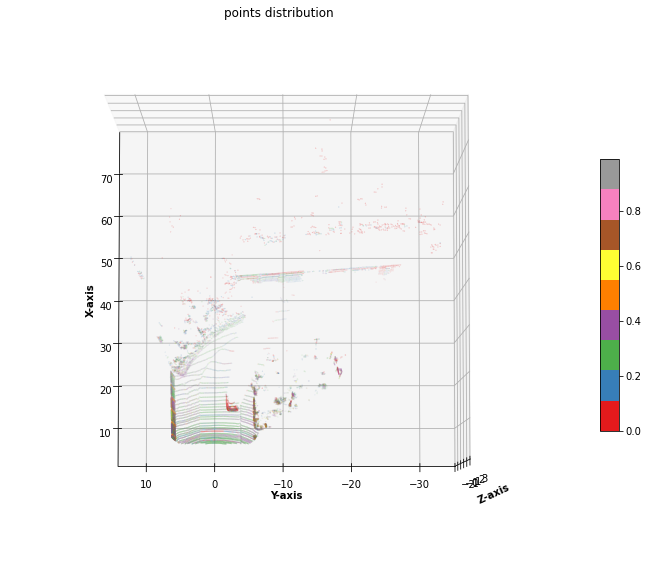

In [10]:
px = 1/plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1280*px, 720*px))
ax = plt.axes(projection ='3d')
my_cmap = plt.get_cmap('Set1')
x = example['points'][:, 1].cpu()
y = example['points'][:, 2].cpu()
z = example['points'][:, 3].cpu()
c = example['points'][:, 4].cpu()
sctt = ax.scatter3D(x, y, z, c=c, cmap=my_cmap, s=0.01)
ax.set_title('points distribution')
ax.view_init(85, 180)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 15)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

In [11]:
example['voxels'][:3], example['voxels'].shape

(tensor([[[21.3700,  5.6250,  0.9560,  0.4200],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[21.1320,  5.6330,  0.9490,  0.3600],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[20.8850,  5.6370,  0.9410,  0.3900],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]], device='cuda:0'),
 torch.Size([16667, 5, 4]))

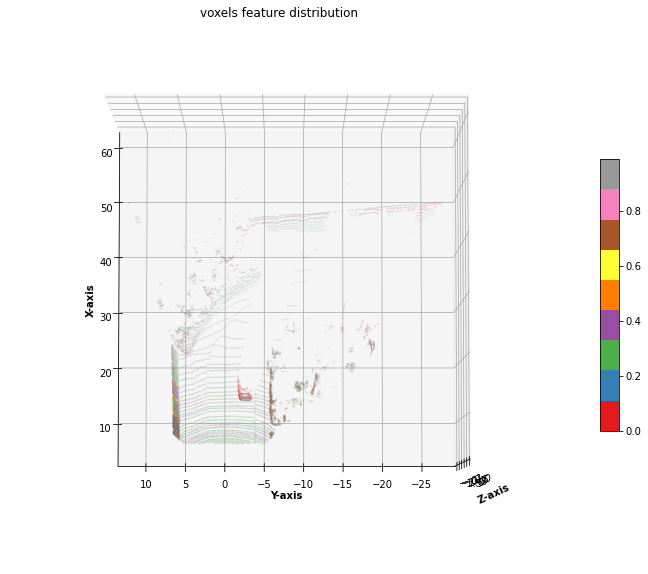

In [12]:
points_mean = example['voxels'].sum(dim=1, keepdim=False) / example['num_points'].type_as(example['voxels']).view(-1, 1)

px = 1/plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1280*px, 720*px))
ax = plt.axes(projection ='3d')
my_cmap = plt.get_cmap('Set1')
x = points_mean[:, 0].cpu()
y = points_mean[:, 1].cpu()
z = points_mean[:, 2].cpu()
c = points_mean[:, 3].cpu()
sctt = ax.scatter3D(x, y, z, c=c, cmap=my_cmap, s=0.01)
ax.set_title('voxels feature distribution')
ax.view_init(85, 180)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 15)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

In [13]:
example['shape']

array([[1408, 1600,   40]])

In [14]:
example['num_points'][:20], example['num_points'].shape

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        device='cuda:0', dtype=torch.int32),
 torch.Size([16667]))

In [15]:
example['num_voxels']

tensor([16667], device='cuda:0')

In [16]:
example['coordinates'][:5], example['coordinates'].shape

(tensor([[  0,  39, 912, 427],
         [  0,  39, 912, 422],
         [  0,  39, 912, 417],
         [  0,  39, 912, 413],
         [  0,  39, 912, 408]], device='cuda:0', dtype=torch.int32),
 torch.Size([16667, 4]))

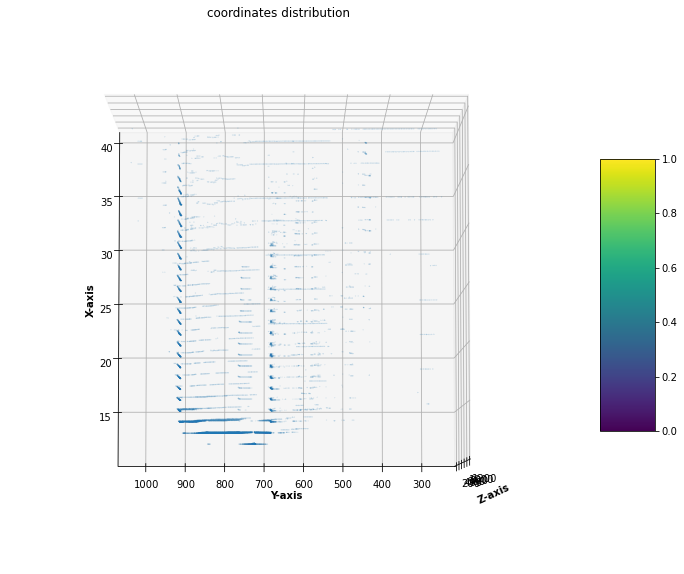

In [17]:
px = 1/plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1280*px, 720*px))
ax = plt.axes(projection ='3d')
x = example['coordinates'][:, 1].cpu()
y = example['coordinates'][:, 2].cpu()
z = example['coordinates'][:, 3].cpu()
sctt = ax.scatter3D(x, y, z, s=0.01)
ax.set_title('coordinates distribution')
ax.view_init(85, 180)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

In [18]:
torch.unique(example['anchors'][0][...,:16,3:7],dim=-2), example['anchors'][0].shape

(tensor([[[1.6000, 3.9000, 1.5600, 0.0000],
          [1.6000, 3.9000, 1.5600, 1.5700]]], device='cuda:0'),
 torch.Size([1, 70400, 7]))

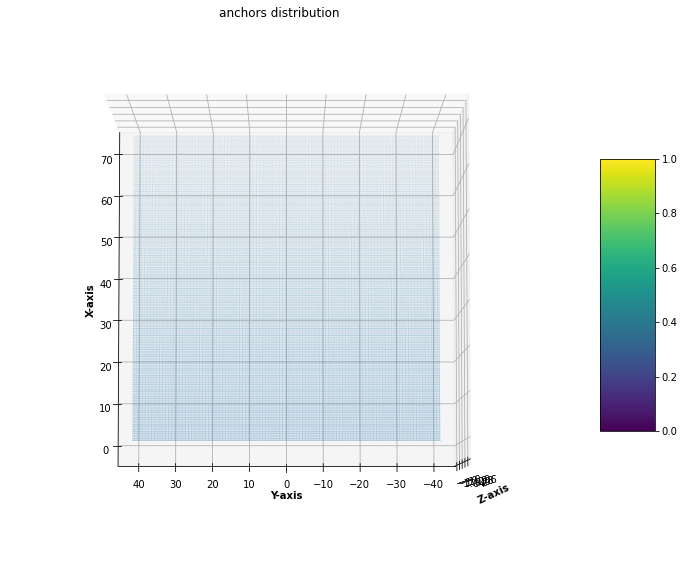

In [19]:
px = 1/plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1280*px, 720*px))
ax = plt.axes(projection ='3d')
x = example['anchors'][0][0][:, 0].cpu()
y = example['anchors'][0][0][:, 1].cpu()
z = example['anchors'][0][0][:, 2].cpu()
sctt = ax.scatter3D(x, y, z, s=0.01)
ax.set_title('anchors distribution')
ax.view_init(85, 180)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

In [20]:
example['calib']

{'rect': tensor([[[ 0.9999,  0.0098, -0.0074,  0.0000],
          [-0.0099,  0.9999, -0.0043,  0.0000],
          [ 0.0074,  0.0044,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
        dtype=torch.float64),
 'Trv2c': tensor([[[ 7.5337e-03, -9.9997e-01, -6.1660e-04, -4.0698e-03],
          [ 1.4802e-02,  7.2807e-04, -9.9989e-01, -7.6316e-02],
          [ 9.9986e-01,  7.5238e-03,  1.4808e-02, -2.7178e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
        device='cuda:0', dtype=torch.float64),
 'P2': tensor([[[7.2154e+02, 0.0000e+00, 6.0956e+02, 4.4857e+01],
          [0.0000e+00, 7.2154e+02, 1.7285e+02, 2.1638e-01],
          [0.0000e+00, 0.0000e+00, 1.0000e+00, 2.7459e-03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]], device='cuda:0',
        dtype=torch.float64),
 'frustum': tensor([[[[[ 2.7114e-01,  5.8722e-02, -7.1781e-02],
            [ 2.7115e-01,  5.8728e-02, -7.2301e-02],
            [ 2.7115e-01,

In [21]:
example['annos']

array([{'boxes': array([[15.8694027 , -2.67297704, -0.83769372,  1.61000001,  4.36999989,
         1.39999998, -1.61000001]]), 'names': array(['Car'], dtype='<U3')}],
      dtype=object)

In [22]:
samples = []
for id in [15]:
    index = valid_ids.index(id)
    samples.append(kitti_dataset[index])
batch_samples = collate_kitti(samples)
example = example_to_device(batch_samples, device=torch.device('cuda'))
[k for k,v in example.items()]

['metadata',
 'points',
 'voxels',
 'shape',
 'num_points',
 'num_voxels',
 'coordinates',
 'anchors',
 'calib',
 'annos']

In [23]:
del example['metadata']
#del example['points']
#del example['voxels']
#del example['shape']
#del example['num_points']
#del example['num_voxels']
#del example['coordinates']
#del example['anchors']
del example['calib']
example['annos']

array([{'boxes': array([[ 1.24901945e+01,  3.19828260e+00, -8.75990480e-01,
         1.66999996e+00,  3.80999994e+00,  1.64999998e+00,
        -1.60000002e+00],
       [ 8.75001136e+00, -3.16372953e+00, -8.67281997e-01,
         1.50999999e+00,  3.09999990e+00,  1.51999998e+00,
        -1.59000003e+00],
       [ 1.34302127e+01, -2.88263489e+00, -8.60406552e-01,
         1.58000004e+00,  3.52999997e+00,  1.52999997e+00,
        -1.59000003e+00],
       [ 2.25567532e+01,  3.49666553e+00, -2.26066578e-02,
         2.05999994e+00,  5.42000008e+00,  2.59999990e+00,
         1.55999994e+00],
       [ 2.66997560e+01, -2.69067814e+00, -7.84707430e-01,
         1.60000002e+00,  3.71000004e+00,  1.46000004e+00,
        -1.53999996e+00],
       [ 5.21904385e+01, -1.72523721e+00, -4.73138346e-01,
         1.82000005e+00,  4.40999985e+00,  1.97000003e+00,
        -1.58000004e+00]]), 'names': array(['Car', 'Car', 'Car', 'Truck', 'Car', 'Van'], dtype='<U8')}],
      dtype=object)

In [24]:
res = {
            "lidar": {
                "type": "lidar",
                "points": example['points'][:, 1:5].cpu().numpy(),
                "targets": None,      # include cls_labels & reg_targets
            },
            "mode": "test",
            "metadata": None
        }

In [25]:
from det3d.datasets.pipelines import Compose
pipeline = Compose(cfg.online_execute_pipeline)

In [26]:
data, _ = pipeline(res, None)

In [27]:
import numpy as np
np.unique(data['anchors'][0][...,:16,3:7],axis=-2), \
np.unique(data['anchors'][1][...,:16,3:7],axis=-2), \
np.unique(data['anchors'][2][...,:16,3:7],axis=-2), \
data['anchors'][0].shape

(array([[1.6 , 3.9 , 1.56, 0.  ],
        [1.6 , 3.9 , 1.56, 1.57]], dtype=float32),
 array([[0.6 , 0.8 , 1.73, 0.  ],
        [0.6 , 0.8 , 1.73, 1.57]], dtype=float32),
 array([[0.6 , 1.76, 1.73, 0.  ],
        [0.6 , 1.76, 1.73, 1.57]], dtype=float32),
 (70400, 7))

In [28]:
voxels = data['voxels']
voxels[data['num_points'].argmax()]


array([[ 7.48 , -2.638, -0.729,  0.5  ],
       [ 7.494, -2.63 , -0.73 ,  0.32 ],
       [ 7.466, -2.649, -0.773,  0.73 ],
       [ 7.465, -2.622, -0.772,  0.71 ],
       [ 7.49 , -2.604, -0.774,  0.47 ]], dtype=float32)

In [29]:
examp = example_to_device(collate_kitti([data]), device=torch.device('cuda'))

In [30]:
examp

{'metadata': [None],
 'points': tensor([[ 0.0000e+00,  2.1751e+01,  2.5340e+00,  9.5000e-01,  4.2000e-01],
         [ 0.0000e+00,  2.1762e+01,  2.6050e+00,  9.5000e-01,  6.0000e-01],
         [ 0.0000e+00,  2.1766e+01,  2.6750e+00,  9.5100e-01,  5.9000e-01],
         ...,
         [ 0.0000e+00,  6.5520e+00, -5.4000e-02, -1.7150e+00,  1.5000e-01],
         [ 0.0000e+00,  6.5500e+00, -3.3000e-02, -1.7150e+00,  2.9000e-01],
         [ 0.0000e+00,  6.5480e+00, -1.3000e-02, -1.7140e+00,  2.5000e-01]],
        device='cuda:0'),
 'voxels': tensor([[[ 2.1751e+01,  2.5340e+00,  9.5000e-01,  4.2000e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
 
         [[ 2.1762e+01,  2.6050e+00,  9.5000e-01,  6.0000e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [

In [31]:
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint_path = os.path.join("../exp_se_ssd_v1_8", "se-ssd-model-transfer.pth")
checkpoint = load_checkpoint(model, checkpoint_path, map_location="cpu")

In [32]:
checkpoint['optimizer']['state'].keys()

dict_keys([140683296457568, 140683296458216, 140683296458864, 140683296459512, 140683296460160, 140683296522312, 140683296522960, 140683296523608, 140683296524256, 140683296524904, 140683296525552, 140683296526200, 140683296567872, 140683296568520, 140683296569240, 140683296569888, 140683296570536, 140683296571184, 140683296653816, 140683296654464, 140683296655184, 140683296655904, 140683296656624, 140683296657344, 140683296195280, 140683296196000, 140683296196648, 140683296197368, 140683296271816, 140683296272032, 140683296293728, 140683296294232, 140683296334328, 140683296334472, 140683296334400, 140683296334688, 140683296457496, 140683296457712, 140683296458144, 140683296458360, 140683296458792, 140683296459008, 140683296459440, 140683296459656, 140683296460088, 140683296460304, 140683296522384, 140683296522456, 140683296522888, 140683296523104, 140683296523536, 140683296523752, 140683296524184, 140683296524400, 140683296524832, 140683296525048, 140683296525480, 140683296525696, 140

In [33]:
model = MegDataParallel(model, device_ids=[0])
print(model)

MegDataParallel(
  (module): VoxelNet(
    (reader): VoxelFeatureExtractorV3()
    (backbone): SpMiddleFHD(
      (middle_conv): SparseSequential(
        (0): SubMConv3d()
        (1): BatchNorm1d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): SubMConv3d()
        (4): BatchNorm1d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): SparseConv3d()
        (7): BatchNorm1d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): SubMConv3d()
        (10): BatchNorm1d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (11): ReLU()
        (12): SubMConv3d()
        (13): BatchNorm1d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (14): ReLU()
        (15): SparseConv3d()
        (16): BatchNorm1d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (17): ReLU()
 

In [34]:
with torch.no_grad():
    # outputs: predicted results in lidar coord.
    outputs = model(examp, return_loss=False, rescale=True)

In [35]:
outputs

[{'box3d_lidar': tensor([[ 12.6476,   3.3091,  -0.8771,   1.6708,   4.2013,   1.5731,   4.6632],
          [  8.8111,  -3.2448,  -0.8363,   1.5734,   3.2481,   1.5917,   4.7347],
          [ 26.6175,  -2.7054,  -0.7917,   1.6741,   3.5609,   1.4714,   4.7462],
          [ 13.5381,  -2.8619,  -0.9411,   1.5914,   3.5972,   1.5351,   4.6381],
          [ 22.2957,   3.4187,  -0.2555,   2.0526,   6.1297,   2.5000,   1.5713],
          [ 22.5497,  15.8281,  -1.0221,   1.6148,   4.1045,   1.4306,   4.6863],
          [ 52.4032,  -1.8464,  -0.5163,   1.9294,   4.7983,   1.9648,   4.7042],
          [  2.3614,  -2.8141,  -1.0457,   1.5843,   4.0110,   1.4402,   1.7379],
          [ 21.3408, -14.2113,  -0.5356,   1.6474,   4.0538,   1.5164,   2.0998],
          [ 12.3062,   3.3784,  -0.4637,   0.6266,   0.8618,   1.7446,   4.6632],
          [  8.9552,  -3.0581,  -0.4185,   0.5900,   0.6663,   1.7651,   4.7347],
          [ 13.2239,   3.3761,  -0.5021,   0.6357,   0.8625,   1.7522,   4.6722],
 

In [36]:
with torch.no_grad():
    # outputs: predicted results in lidar coord.
    outputs = model(example, return_loss=False, rescale=True)

In [37]:
outputs

[{'box3d_lidar': tensor([[ 12.6476,   3.3091,  -0.8771,   1.6708,   4.2013,   1.5731,   4.6632],
          [  8.8111,  -3.2448,  -0.8363,   1.5734,   3.2481,   1.5917,   4.7347],
          [ 26.6175,  -2.7054,  -0.7917,   1.6741,   3.5609,   1.4714,   4.7462],
          [ 13.5381,  -2.8619,  -0.9411,   1.5914,   3.5972,   1.5351,   4.6381],
          [ 22.2957,   3.4187,  -0.2555,   2.0526,   6.1297,   2.5000,   1.5713],
          [ 22.5497,  15.8281,  -1.0221,   1.6148,   4.1045,   1.4306,   4.6863],
          [ 52.4032,  -1.8464,  -0.5163,   1.9294,   4.7983,   1.9648,   4.7042],
          [  2.3614,  -2.8141,  -1.0457,   1.5843,   4.0110,   1.4402,   1.7379],
          [ 21.3408, -14.2113,  -0.5356,   1.6474,   4.0538,   1.5164,   2.0998],
          [ 12.3062,   3.3784,  -0.4637,   0.6266,   0.8618,   1.7446,   4.6632],
          [  8.9552,  -3.0581,  -0.4185,   0.5900,   0.6663,   1.7651,   4.7347],
          [ 13.2239,   3.3761,  -0.5021,   0.6357,   0.8625,   1.7522,   4.6722],
 

In [38]:
x = torch.randn(3,4,5)
print(x)
bn = torch.nn.BatchNorm1d(4)
y = bn(x)
print(y)
z = torch.randn(3,1).type_as(x)
print(z)
xs = x.sum(dim=1, keepdim=False)
print(xs)
xsz = xs * z
print(xsz)
y[:,:,-1]

tensor([[[ 0.3857,  1.3630,  1.1220,  1.4695, -0.1277],
         [ 2.1427, -0.0341,  1.2228, -1.2190, -0.3322],
         [-0.1556,  1.7119, -1.6253,  0.9635,  0.1339],
         [ 0.1845,  0.8776,  0.7893,  0.6344, -0.6411]],

        [[-0.5320,  1.1253, -0.1192,  1.2006, -0.0040],
         [ 0.0176, -1.1863,  0.6949,  1.4748,  0.1688],
         [-0.5139, -0.9126, -0.0255, -2.2359, -0.3356],
         [ 0.6608,  1.1052, -0.0153, -3.0241, -2.3784]],

        [[ 1.0122,  1.1236, -0.2290,  0.4593, -0.2059],
         [-0.5416, -0.0734,  0.9910, -0.3656,  0.7416],
         [-0.9225,  0.1818, -1.3184, -0.4602, -0.2935],
         [-1.2155,  1.0349, -0.8661,  0.8312,  0.1441]]])
tensor([[[-0.2247,  1.2346,  0.8748,  1.3937, -0.9916],
         [ 2.0500, -0.3038,  1.0554, -1.5850, -0.6261],
         [ 0.2448,  2.2189, -1.3088,  1.4278,  0.5509],
         [ 0.2530,  0.8192,  0.7471,  0.6206, -0.4214]],

        [[-1.5953,  0.8797, -0.9787,  0.9922, -0.8068],
         [-0.2478, -1.5497,  0.4846,  1.

tensor([[-0.9916, -0.6261,  0.5509, -0.4214],
        [-0.8068, -0.0844,  0.0546, -1.8407],
        [-1.1082,  0.5350,  0.0990,  0.2200]], grad_fn=<SelectBackward>)